In [11]:
import os
import openai
from datasets import load_dataset
from PIL import Image
from IPython.display import display
import io, re
import base64
import json

In [12]:
print(openai.__version__)

1.57.0


In [13]:
key = "Your API key"

In [14]:
client = openai.OpenAI(
    api_key=key  # This is the default and can be omitted
)

In [15]:
# Load the dataset
dataset = load_dataset("ziyu3141/rf_train_100_2")

In [16]:
def match_misalignment_label_to_token(
    misalignment_label,
    prompt,
):
  delimiters = ',.?!":; '
  pattern = '|'.join(map(re.escape, delimiters))
  # Split by punctuation or space and remove empty tokens.
  tokens = re.split(pattern, prompt)
  tokens = [t for t in tokens if t]

  misalignment_label = misalignment_label.split(' ')
  misalignment_label = [int(l) for l in misalignment_label]
  assert len(tokens) == len(misalignment_label)
  return list(zip(tokens, misalignment_label))

In [22]:
def show_img(byte_img):

    # Open the image with PIL
    image = Image.open(byte_img)

    # Display the image in the notebook
    display(image)

In [23]:
inst = []

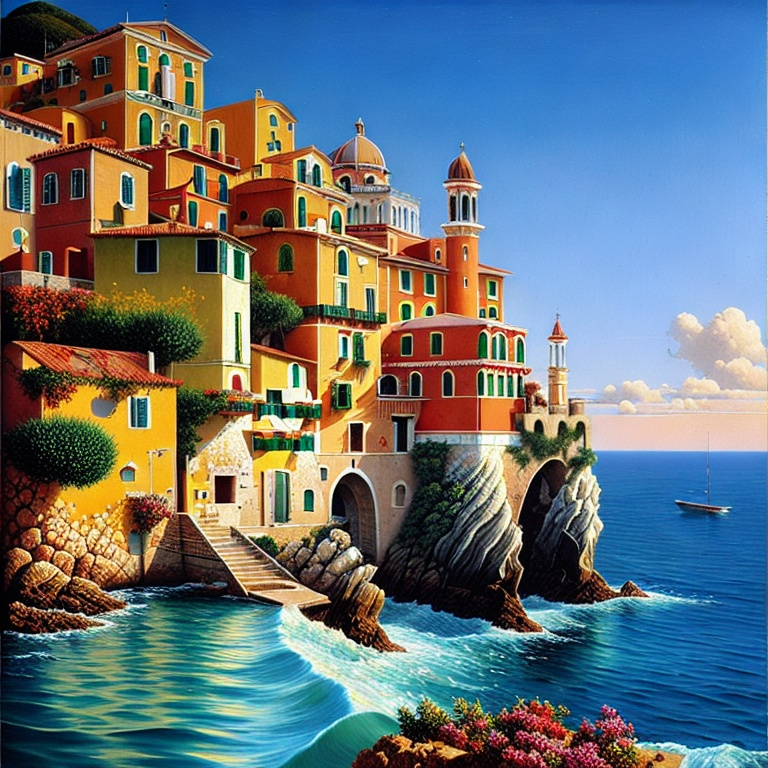

Editing Instructions for sample 0:
Add Italian flags on some buildings; Include a more rugged coastline; Enhance classical Italian architecture elements; Expand visible ocean area.


In [24]:
# Iterate through the dataset (for demonstration, just do one sample)
for i, sample in enumerate(dataset['train']):
    # Get the required data from the datasets
    image_preferred = sample.get("image_preferred")
    prompt = sample.get("prompt")
    misalignment_token_label = sample.get('Misalignment token label')
    misalignment_heatmap = sample.get('Misalignment heatmap')
    
    image_file = io.BytesIO(image_preferred)
    show_img(image_file)
    raw_data = image_file.getvalue()
    img_str = base64.b64encode(raw_data).decode('utf-8')
    
    pairs = match_misalignment_label_to_token(misalignment_token_label, prompt)
    
    mis_pairs = json.dumps(pairs)
    mis_heatmap = json.dumps(misalignment_heatmap)


#     # Call the GPT-4 model
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
                {
                  "role": "system",
                  "content": f"You are an AI assistant that provides 2-3 concise suggestions (separated by a semicolon) with each suggestion being no more than 8 words. Please make sure that each suggestion suggests concrete change, not just a high-level idea. Your goal is to improve images so they better align with the prompt: {prompt}."
                },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f'I want you to give short, concise editing instructions based on the following inputs regarding misalignment information. Some instructions are (1) Keep it concise: Change the red dog to yellow is better than Please make the dog that is red in the image a bright yellow color. (2) Be specific: Avoid ambiguous instructions like Make it more colorful. Instead, use Change the red dog to yellow and make the background green. (3) Avoid redundancy: Don’t repeat the same intent multiple times. The image is the generated image based on the prompt: {prompt}.'},
                    {"type": "text", "text": "Here, we have the list of pairs where the first element is a word in the prompt, and the second element is 1 if there's misalignment for this word, and 0 otherwise"},
                    {"type": "text", "text": f"list of pairs: {mis_pairs}"},
                   # {"type": "text", "text": "We also have a heatmap, which is a 2D matrix, and 1 means that there's a misalignment in that pixel "},
                   # {"type": "text", "text": f"heatmap: {mis_heatmap}"},
                    {"type": "text", "text": "Please give short editing instructions for the image to solve the misalignment as a text string, where instructions are separated by a semicolon."},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{img_str}"},
                    },
                ],
            }
        ],
    )

#     # Extract the assistant's answer
    editing_instructions = response.choices[0].message.content.strip()
    print(f"Editing Instructions for sample {i}:\n{editing_instructions}")
    inst.append(editing_instructions)